<a href="https://colab.research.google.com/github/DhakalAmrit/time_series_forecasting/blob/main/Lithium_ion_Battery_State_of_Charge_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
aditya9790_lg_18650hg2_liion_battery_data_path = kagglehub.dataset_download('aditya9790/lg-18650hg2-liion-battery-data')

print('Data source import complete.')


100%|██████████| 78.7M/78.7M [00:00<00:00, 89.1MB/s]

Extracting files...


Data source import complete.



# Time series forecasting framework
---


## Step 1: DEFINING THE PROBLEM

**<span style="color:red">1. Input vs. Output </span>**
- **Input (Predictors, Features, Independent Variables):** The variables used to predict future values. Can be past observations (lags), external factors, or other auxiliary data.  
- **Output (Target, Dependent Variable, Response):** The variable we aim to predict (e.g., battery SOC, temperature, stock price).  

🔹 Example: Predicting battery **SOC** using past voltage, current, and temperature.  
  - **Inputs:** Voltage, Current, Temperature  
  - **Output:** SOC  



**<span style="color:red">2. Endogenous vs. Exogenous Variables**
- **Endogenous Variables:** Variables that are influenced by other variables in the system and can be predicted using past values (e.g., SOC, SOH in battery models).  
- **Exogenous Variables:** External factors that influence the system but are not predicted (e.g., ambient temperature, driving profile in battery models).  

🔹 Example: Predicting battery health degradation.  
  - **Endogenous:** Battery voltage, internal resistance  
  - **Exogenous:** Ambient temperature, charging current profile  



**<span style="color:red">3. Structured vs. Unstructured Data**  
- **Structured Data:** Organized in tabular format with defined columns (e.g., time series, sensor readings, financial data).  
- **Unstructured Data:** Raw data without a fixed format (e.g., images, audio, text logs).  

🔹 Example:  
  - **Structured:** Battery voltage and current readings in a table  
  - **Unstructured:** Electrochemical impedance spectroscopy (EIS) plots, text-based battery logs  



**<span style="color:red">4. Regression vs. Classification**
- **Regression:** Predicts a continuous numerical value (e.g., SOC estimation, temperature forecasting).  
- **Classification:** Predicts a discrete class label (e.g., battery health: ‘Good’, ‘Moderate’, ‘Degraded’).  

🔹 Example:  
  - **Regression:** Predicting SOC as a percentage (0% to 100%)  
  - **Classification:** Categorizing SOH into ‘Healthy’, ‘Warning’, ‘Critical’  



**<span style="color:red">5. Univariate vs. Multivariate**
- **Univariate:** A single variable is used for prediction (e.g., SOC estimated based only on voltage).  
- **Multivariate:** Multiple variables are used (e.g., SOC estimated using voltage, current, and temperature).  

🔹 Example:  
  - **Univariate:** Predicting future battery voltage using past voltage values  
  - **Multivariate:** Predicting battery SOC using voltage, current, and temperature  



**<span style="color:red">6. Single-Step vs. Multi-Step Forecasting**
- **Single-Step Forecasting:** Predicts the next time step only.  
- **Multi-Step Forecasting:** Predicts multiple future time steps (e.g., next 10 minutes, next hour).  

🔹 Example:  
  - **Single-Step:** Predicting SOC at the next second  
  - **Multi-Step:** Predicting SOC for the next 10 time steps  



**<span style="color:red">7. Static vs. Dynamic Forecasting**  
- **Static Forecasting:** The model is trained once and used without updates (e.g., pre-trained ML models).  
- **Dynamic Forecasting:** The model updates predictions iteratively based on new incoming data (e.g., Kalman Filters, adaptive ML models).  

🔹 Example:  
  - **Static:** Train an LSTM model once and use it without further updates  
  - **Dynamic:** Update a Kalman Filter with each new measurement for real-time SOC estimation  



**<span style="color:red">8. Contiguous vs. Discontinuous Time Series**  
- **Contiguous (Continuous) Time Series:** Data points are recorded at fixed time intervals without missing values.  
- **Discontinuous (Sparse) Time Series:** Data has missing or irregular time gaps.  

🔹 Example:  
  - **Contiguous:** Battery voltage recorded every second  
  - **Discontinuous:** Battery voltage recorded only during charge cycles  


This categorization is useful for defining forecasting problems, especially in applications like **battery modeling, state estimation, and predictive maintenance**.

| **Aspect**       | **Description** |
|------------------|----------------|
| **Input vs Output** | - **Input:** Voltage, current, temperature, internal resistance, cycle count, etc. <br> - **Output:** State of Charge (SOC) or State of Health (SOH) |
| **Endogenous vs Exogenous** | - **Endogenous:** Features directly derived from the battery system (voltage, current, internal resistance). <br> - **Exogenous:** External factors influencing the battery (ambient temperature, driving profile). |
| **Unstructured vs Structured** | - **Structured:** Tabular battery data (time-series values). <br> - **Unstructured:** Rarely applicable, but sensor logs/images of battery degradation could be unstructured data. |
| **Regression vs Classification** | - **Regression:** Predicting SOC (continuous value, e.g., 80.5%). <br> - **Classification:** Categorizing SOH (e.g., "Healthy", "Moderate", "Degraded"). |
| **Univariate vs Multivariate** | - **Univariate:** Predicting SOC/SOH using only voltage data. <br> - **Multivariate:** Using multiple sensor readings (voltage, current, temperature, etc.). |
| **Single-Step vs Multi-Step** | - **Single-Step:** Predicting the next SOC value based on previous observations. <br> - **Multi-Step:** Forecasting future SOC/SOH over multiple time steps. |
| **Static vs Dynamic** | - **Static:** Models trained on historical data without real-time updates. <br> - **Dynamic:** Models continuously updating as new battery data comes in. |
| **Contiguous vs Discrete** | - **Contiguous:** Continuous SOC/SOH estimation across all time steps. <br> - **Discrete:** Predicting SOC/SOH at specific points (e.g., after every charging cycle). |


##  Step 2: DESIGN TEST HARNESS


Designing a **test harness** involves setting up a structured environment to evaluate different models systematically. Here's how you can structure it for **battery SOC/SOH estimation** using **baseline models, machine learning, and deep learning approaches**.  

**<span style="color:red">1. Define the Objective**
The test harness should evaluate models for:  
- **Accuracy:** How close the predictions are to actual values.  
- **Generalization:** How well the model performs on unseen data.  
- **Efficiency:** Computational cost and inference speed.  
- **Robustness:** Stability across different battery datasets and conditions.  



**<span style="color:red">2. Data Preparation**  
- **Dataset Selection:** Use NASA, Oxford, or your own collected battery cycling datasets.  
- **Preprocessing:**  
  - Handle missing values.  
  - Normalize/standardize features.  
  - Feature selection: Voltage, current, temperature, internal resistance.  
- **Splitting Data:**  
  - **Train-Test Split:** 80%-20% (or k-fold cross-validation).  
  - **Time-Based Split:** Training on past cycles, testing on future ones.  



**<span style="color:red">3. Baseline Models for Benchmarking**  
Start with simple models before using complex ones:  
1. **Persistence Model (Naïve Forecasting):** Uses the last observed value as the next prediction.  
2. **Moving Average:** Averages past observations to predict the next value.  
3. **Autoregression (AR):** Uses past time steps to predict the next step.  
4. **Exponential Smoothing (SES, Holt-Winters):** Weighs recent observations more heavily.  

🔹 **Purpose:** Baseline comparison—any ML/DL model should outperform these.  



**<span style="color:red">4. Machine Learning Models**  
Test traditional ML models with **time-series features** (lags, rolling stats):  
- **Linear Models:** Linear Regression, Ridge, LASSO  
- **Tree-Based Models:** Decision Trees, Random Forest, XGBoost  
- **Non-Linear Models:** Support Vector Regression (SVR), k-NN  

🔹 **Feature Engineering:** Include lagged values, derivatives, and external factors.  



**<span style="color:red">5. Deep Learning Models**
Use sequential models for complex dependencies:  
- **RNN, LSTM, GRU:** Capture long-term dependencies.  
- **CNN:** Extract patterns from battery time-series data.  
- **Transformer Models:** Handle long-range dependencies (e.g., Time-Series Transformer).  

🔹 **Challenge:** Requires **large datasets** and **high computational resources**.  



**<span style="color:red">6. Model Training & Evaluation**
- **Loss Functions:**  
  - Regression: MSE, RMSE, MAE  
  - Classification (if used for SOH states): Cross-Entropy Loss  
- **Metrics:**  
  - **RMSE / MAE** (for SOC prediction)  
  - **R² Score** (goodness of fit)  
  - **MAPE** (Mean Absolute Percentage Error for scale-independent evaluation)  
- **Cross-Validation:** k-fold or rolling window approach.  



**<span style="color:red">7. Model Deployment Considerations**  
- **Real-Time vs. Offline:** Can the model run on embedded systems (e.g., BMS)?  
- **Computational Efficiency:** Does it require high-power GPUs?  
- **Robustness Testing:** Evaluate model performance across different battery types and temperatures.  



**<span style="color:red">Final Step: Compare & Select the Best Model**  
- Compare baseline models vs. ML/DL models.  
- Choose a model balancing **accuracy, efficiency, and deployment feasibility**.  
- Fine-tune hyperparameters and validate on real-world battery data.  

| **Step** | **Component** | **Description** |
|---------|-------------|----------------|
| **1. Objective** | Define Goal | Evaluate and compare models for SOC/SOH estimation based on accuracy, efficiency, and robustness. |
| **2. Data Preparation** | Dataset Selection | Use NASA, Oxford, or self-collected battery datasets. |
|  | Data Preprocessing | Handle missing values, normalize data, extract relevant features (voltage, current, temperature, internal resistance). |
|  | Splitting Strategy | Train-Test Split (80%-20%) or Time-Based Split (past cycles for training, future cycles for testing). |
| **3. Baseline Models** | Persistence Model | Uses the last observed value as the next prediction. |
|  | Moving Average | Averages past SOC/SOH values for prediction. |
|  | Autoregression (AR) | Uses past time steps to predict the next value. |
|  | Exponential Smoothing | Weighs recent observations more heavily. |
| **4. Machine Learning Models** | Linear Models | Linear Regression, Ridge Regression, LASSO. |
|  | Tree-Based Models | Decision Trees, Random Forest, XGBoost. |
|  | Non-Linear Models | Support Vector Regression (SVR), k-Nearest Neighbors (k-NN). |
| **5. Deep Learning Models** | Recurrent Networks | LSTM, GRU for time-series forecasting. |
|  | Convolutional Models | CNN for feature extraction from battery signals. |
|  | Transformers | Time-Series Transformer for long-range dependencies. |
| **6. Model Training & Evaluation** | Loss Functions | MSE, RMSE, MAE for regression; Cross-Entropy for classification. |
|  | Performance Metrics | RMSE, MAE, R² Score, MAPE for SOC/SOH prediction. |
|  | Cross-Validation | k-Fold or Rolling Window approach for model validation. |
| **7. Deployment Considerations** | Real-Time vs Offline | Determine if the model runs on embedded systems (BMS) or offline analysis. |
|  | Computational Efficiency | Check GPU/CPU requirements for model inference. |
|  | Robustness Testing | Evaluate performance across different battery types and temperatures. |
| **8. Final Model Selection** | Compare Models | Choose the best model based on accuracy, efficiency, and robustness. |
|  | Fine-Tuning | Optimize hyperparameters for best performance. |



##  Step 3: TEST MODELS SELECTION

**<span style="color:red">1. Baseline Forecasting Methods (Simple Methods)**
These models serve as simple benchmarks for more complex models.

- **Persistence (Naïve) Method** – Uses the last observed value as the forecast.
- **Simple Moving Average (SMA)** – Averages the last `n` values.
- **Cumulative Moving Average (CMA)** – Averages all values up to the current point.
- **Weighted Moving Average (WMA)** – Assigns different weights to past values.
- **Seasonal Naïve Method** – Uses values from the previous season (e.g., last year's same month).
- **Drift Method** – Extends the trend line based on past observations.
- **Rolling Mean/Median Forecast** – Uses rolling statistics over time.



**<span style="color:red">2. Autoregressive Models (Time Series Specific)**
These models rely on past observations to predict future values.

- **Autoregressive (AR) Model** – Forecasts based on past values in a linear way.
- **Moving Average (MA) Model** – Uses past forecast errors for prediction.
- **Autoregressive Moving Average (ARMA)** – Combines AR and MA models.
- **Autoregressive Integrated Moving Average (ARIMA)** – ARMA with differencing for non-stationary series.
- **Seasonal ARIMA (SARIMA)** – Extends ARIMA with seasonal components.
- **SARIMAX (SARIMA with Exogenous Variables)** – Incorporates external factors.
- **Vector Autoregression (VAR)** – Extends AR to multiple time series.
- **Vector Autoregression Moving-Average (VARMA)** – Extends VAR by adding MA terms.
- **Vector Autoregression Moving-Average with Exogenous Variables (VARMAX)** – Extends VARMA with external regressors.



**<span style="color:red"> 3. Exponential Smoothing Models**
These models give exponentially decreasing weights to past observations.

- **Simple Exponential Smoothing (SES)** – Suitable for time series with no trend/seasonality.
- **Holt’s Linear Trend Model** – Adds trend components.
- **Holt-Winters Method (Triple Exponential Smoothing)** – Adds seasonal adjustments.



**<span style="color:red">4. Linear Machine Learning Models**
These models use traditional machine learning techniques for forecasting.

- **Linear Regression** – Uses past observations as features.
- **Ridge Regression** – Linear regression with L2 regularization.
- **Lasso Regression** – Linear regression with L1 regularization.
- **Elastic Net** – Combination of Lasso and Ridge.



**<span style="color:red"> 5. Non-Linear Machine Learning Models**
These models capture non-linear patterns in time series.

- **Support Vector Regression (SVR)** – Uses support vector machines for regression.
- **Decision Trees (DT)** – Rule-based split on past observations.
- **K-Nearest Neighbors (KNN) Regression** – Predicts based on the closest `k` past values.



**<span style="color:red">6. Ensemble Machine Learning Models**
These models combine multiple learners to improve forecasting accuracy.

- **Random Forest Regressor** – Uses multiple decision trees and averages their outputs.
- **Gradient Boosting Machines (GBM)** – Builds trees sequentially to minimize errors.
- **XGBoost** – Optimized version of gradient boosting.
- **LightGBM** – Faster, memory-efficient version of gradient boosting.
- **CatBoost** – Optimized for categorical features.
- **Stacked Models** – Combines multiple machine learning models.



**<span style="color:red">7. Deep Learning Models**
These models leverage neural networks for time-series forecasting.

**Recurrent Neural Networks (RNNs)**
- **Simple RNN** – Uses recurrent connections for sequence learning.
- **Long Short-Term Memory (LSTM)** – Addresses vanishing gradient issues in RNNs.
- **Gated Recurrent Unit (GRU)** – Simplified version of LSTM.

**Convolutional Neural Networks (CNNs) for Time-Series**
- **1D CNN** – Applies convolution over time series data.
- **TCN (Temporal Convolutional Network)** – Uses causal convolutions.

**Hybrid & Attention-Based Models**
- **CNN-LSTM** – Combines CNN feature extraction with LSTM forecasting.
- **Transformer-Based Models** – Uses self-attention mechanisms (e.g., **Temporal Fusion Transformer (TFT)**).
- **N-BEATS (Neural Basis Expansion)** – Interpretable deep learning model.

**Variational & Generative Models**
- **Variational Autoencoder (VAE) for Time-Series**
- **GAN-based Time Series Models (TimeGAN, TGAN)**



**<span style="color:red">8. Other Advanced Models**
- **Gaussian Process Regression (GPR)** – Non-parametric method for uncertainty estimation.
- **Bayesian Structural Time Series (BSTS)** – Probabilistic forecasting with uncertainty estimation.
- **Prophet (by Facebook/Meta)** – Decomposes trend, seasonality, and holiday effects.



**Conclusion**
If we're working on battery SOC/SOH estimation, we might find **LSTM, GRU, Transformer models, XGBoost, and Random Forest** particularly useful due to their strong performance in capturing non-linear dependencies.

# Data Preparation  with pandas
---


A brand new **3Ah LG HG2 cell** was tested in an **8 cu.ft. thermal chamber with a 75amp**, 5 volt Digatron Firing Circuits Universal Battery Tester channel with a **voltage and current accuracy of 0.1%** of full scale.

---
A series of tests were performed at **six different temperatures**, and the battery was charged after each test at **1C rate to 4.2V, 50mA cut off, with battery temperature 22degC or greater**.  The tests were performed as follows:
1. Four pulse discharge **HPPC test** (1, 2, 4, and 6C discharge and 0.5, 1, 1.5, and 2C charge, with reduced values at lower temperatures) performed at 100, 95, 90, 80, 70..., 20, 15, 10, 5, 2.5, 0 % SOC.   
2. **C/20 Discharge and Charge test**.
3. **0.5C, 2C, and two 1C discharge tests.**  The first 1C discharge test is performed before the UDDS cycle, and the second is performed before the Mix3 cycle.
4. Series of four **drive cycles** performed, in following order: **UDDS, HWFET, LA92, US06.**  
5. A series of **eight drive cycles** (mix 1-8) consist of **random mix of UDDS, HWFET, LA92, US06**. The drive cycle power profile is calculated for a single LG HG2 cell in a compact electric vehicle.
6. The previous tests are **repeated for ambient temperatures of 40degC, 25degC, 10degC, 0degC, -10degC, and -20degC, in that order**. For tests with ambient temperature below 10degC, a reduced regen current limit is set to prevent premature aging of the cells. The drive cycle power profiles are repeated until 95% of the 1C discharge capacity at the respective temperature has been discharged from the cell.



![image.png](attachment:31bf460b-3bfb-4875-96ce-a9dc8c8ed867.png)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install plotly
#!pip install tensorflow
#!pip install seaborn
#!pip install nb_black
#%load_ext lab_black

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Datasets/LG_HG2'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/content/drive/MyDrive/Datasets/LG_HG2/Readme file - Description of Experimental Tests.txt
/content/drive/MyDrive/Datasets/LG_HG2/Plot_results.m
/content/drive/MyDrive/Datasets/LG_HG2/Technical Information and Experimental Test Results for LG 18650HG2.pdf
/content/drive/MyDrive/Datasets/LG_HG2/10degC/567_Charge6.csv
/content/drive/MyDrive/Datasets/LG_HG2/10degC/567_Charge7.csv
/content/drive/MyDrive/Datasets/LG_HG2/10degC/576_Cap_1C.csv
/content/drive/MyDrive/Datasets/LG_HG2/10degC/571_Mixed4.csv
/content/drive/MyDrive/Datasets/LG_HG2/10degC/571_Charge11.csv
/content/drive/MyDrive/Datasets/LG_HG2/10degC/571_Mixed8.csv
/content/drive/MyDrive/Datasets/LG_HG2/10degC/576_Charge1.csv
/content/drive/MyDrive/Datasets/LG_HG2/10degC/576_Charge3.csv
/content/drive/MyDrive/Datasets/LG_HG2/10degC/571_Charge16.csv
/content/drive/MyDrive/Datasets/LG_HG2/10degC/571_Charge14.csv
/content/drive/MyDrive/Datasets/LG_HG2/10degC/571_Charge12.csv
/content/drive/MyDrive/Datasets/LG_HG2/10degC/567_US06.csv
/c

In [ ]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import time, random
from datetime import datetime, timedelta
import pytz, plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os

In [ ]:
!dir "/content/drive/MyDrive/Datasets/LG_HG2/"

0degC	40degC	 Plot_results.m
10degC	n10degC  Readme\ file\ -\ Description\ of\ Experimental\ Tests.txt
25degC	n20degC  Technical\ Information\ and\ Experimental\ Test\ Results\ for\ LG\ 18650HG2.pdf


In [ ]:
!dir "/content/drive/MyDrive/Datasets/LG_HG2"

0degC	40degC	 Plot_results.m
10degC	n10degC  Readme\ file\ -\ Description\ of\ Experimental\ Tests.txt
25degC	n20degC  Technical\ Information\ and\ Experimental\ Test\ Results\ for\ LG\ 18650HG2.pdf


## Data loading

In [ ]:
Main_Path="/content/drive/MyDrive/Datasets/LG_HG2"

In [ ]:
import pandas as pd

# Read the data, specify correct delimiter (comma or tabs), skip irrelevant rows (e.g., metadata)
train1 = os.path.join(Main_Path, "/content/drive/MyDrive/Datasets/LG_HG2/25degC/")

l = os.listdir(train1)
l = [i for i in l if i.endswith(".csv")]
l


['551_Charge6.csv',
 '551_US06.csv',
 '552_Charge14.csv',
 '552_Charge16.csv',
 '549_HPPC.csv',
 '551_Charge5.csv',
 '551_Charge4.csv',
 '551_Charge8.csv',
 '549_Charge.csv',
 '552_Mixed3.csv',
 '551_Mixed1.csv',
 '551_Charge2.csv',
 '551_Charge3.csv',
 '551_LA92.csv',
 '549_Dis_2C.csv',
 '549_Dis_0p5C.csv',
 '549_C20DisCh.csv',
 '551_Mixed2.csv',
 '551_Charge7.csv',
 '552_Charge15.csv',
 '552_Charge11.csv',
 '551_Cap_1C.csv',
 '552_Cap_1C.csv',
 '551_HWFET.csv',
 '552_Charge10.csv',
 '551_Charge1.csv',
 '552_Charge12.csv',
 '552_Charge9.csv',
 '552_Charge13.csv',
 '552_Mixed6.csv',
 '552_PausCycl.csv',
 '552_Mixed7.csv',
 '552_Mixed4.csv',
 '552_Mixed5.csv',
 '551_UDDS.csv',
 '552_Mixed8.csv']

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
# LA92 drive cycle at 25 degree celcius
train1_csv = os.path.join(train1, "551_LA92.csv")
train1_csv

'/content/drive/MyDrive/Datasets/LG_HG2/25degC/551_LA92.csv'

In [ ]:
df_train1=pd.read_csv(train1_csv,skiprows=30)
df_train1.head()

,10/29/2018 3:53:42 AM,39,TABLE,16:50:37.323,00:00:01.673,1,1.1,LG_HG2_CyclesA,4.19155,-0.05108,23.76583,-0.00000,-0.00000.1,5.00000,Unnamed: 14
0,10/29/2018 3:53:42 AM,39,TABLE,16:50:37.423,00:00:01.773,1,1,LG_HG2_CyclesA,4.19088,-0.08173,23.76583,-0.00000,-0.00001,5.0,NaN
1,10/29/2018 3:53:42 AM,39,TABLE,16:50:37.522,00:00:01.872,1,1,LG_HG2_CyclesA,4.19054,-0.08939,23.76583,-0.00000,-0.00002,5.0,NaN
2,10/29/2018 3:53:42 AM,39,TABLE,16:50:37.622,00:00:01.972,1,1,LG_HG2_CyclesA,4.19037,-0.09195,23.76583,-0.00001,-0.00003,5.0,NaN
3,10/29/2018 3:53:42 AM,39,TABLE,16:50:37.723,00:00:02.073,1,1,LG_HG2_CyclesA,4.19037,-0.09195,23.76583,-0.00001,-0.00004,5.0,NaN
4,10/29/2018 3:53:42 AM,39,TABLE,16:50:37.821,00:00:02.171,1,1,LG_HG2_CyclesA,4.19037,-0.09195,23.76583,-0.00001,-0.00005,5.0,NaN


In [ ]:
df_train1.columns = [
    "Time Stamp",
    "Step",
    "Status",
    "Prog Time",
    "Step Time",
    "Cycle",
    "Cycle Level",
    "Procedure",
    "Voltage",
    "Current",
    "Temperature",
    "Capacity",
    "WhAccu",
    "Cnt",
    "Empty",
]

In [ ]:
df_train1 = df_train1.iloc[:, :-1]  # run only once
df_train1.head(3)

,Time Stamp,Step,Status,Prog Time,Step Time,Cycle,Cycle Level,Procedure,Voltage,Current,Temperature,Capacity,WhAccu,Cnt
0,10/29/2018 3:53:42 AM,39,TABLE,16:50:37.423,00:00:01.773,1,1,LG_HG2_CyclesA,4.19088,-0.08173,23.76583,-0.00000,-0.00001,5.0
1,10/29/2018 3:53:42 AM,39,TABLE,16:50:37.522,00:00:01.872,1,1,LG_HG2_CyclesA,4.19054,-0.08939,23.76583,-0.00000,-0.00002,5.0
2,10/29/2018 3:53:42 AM,39,TABLE,16:50:37.622,00:00:01.972,1,1,LG_HG2_CyclesA,4.19037,-0.09195,23.76583,-0.00001,-0.00003,5.0


In [ ]:
df_train1.describe()

,Step,Cycle,Cycle Level,Voltage,Current,Temperature,Capacity,WhAccu,Cnt
count,100763.000000,100763.000000,100763.000000,100763.000000,100763.000000,100763.000000,100763.000000,100763.000000,100763.0
mean,39.119111,3.590197,0.940444,3.702031,-0.926346,24.246026,-1.336233,-4.964102,5.0
std,0.473326,2.064147,0.236663,0.282690,2.406846,0.222317,0.789170,2.811615,0.0
min,39.000000,0.000000,0.000000,2.859260,-12.144700,23.660670,-2.590260,-9.263270,5.0
25%,39.000000,2.000000,1.000000,3.499510,-2.331880,24.081300,-1.999075,-7.365255,5.0
50%,39.000000,4.000000,1.000000,3.716890,-0.155800,24.186460,-1.303810,-4.958720,5.0
75%,39.000000,5.000000,1.000000,3.946430,0.000000,24.396780,-0.663455,-2.591270,5.0
max,41.000000,7.000000,1.000000,4.208720,5.999610,25.027730,-0.000000,-0.000010,5.0


In [ ]:
df_train1.columns

Index(['Time Stamp', 'Step', 'Status', 'Prog Time', 'Step Time', 'Cycle',
       'Cycle Level', 'Procedure', 'Voltage', 'Current', 'Temperature',
       'Capacity', 'WhAccu', 'Cnt'],
      dtype='object')

In [ ]:
df_train1=df_train1[(df_train1["Status"]=="DCH") | (df_train1["Status"]=="TABLE")]
df_train1.head(3)

,Time Stamp,Step,Status,Prog Time,Step Time,Cycle,Cycle Level,Procedure,Voltage,Current,Temperature,Capacity,WhAccu,Cnt
0,10/29/2018 3:53:42 AM,39,TABLE,16:50:37.423,00:00:01.773,1,1,LG_HG2_CyclesA,4.19088,-0.08173,23.76583,-0.00000,-0.00001,5.0
1,10/29/2018 3:53:42 AM,39,TABLE,16:50:37.522,00:00:01.872,1,1,LG_HG2_CyclesA,4.19054,-0.08939,23.76583,-0.00000,-0.00002,5.0
2,10/29/2018 3:53:42 AM,39,TABLE,16:50:37.622,00:00:01.972,1,1,LG_HG2_CyclesA,4.19037,-0.09195,23.76583,-0.00001,-0.00003,5.0


In [ ]:
# here we use absolute value of minimum value in Capacity column because it is a discharge and value is negative
max_discharge = abs(min(df_train1["Capacity"])) # get maximum discharge
max_discharge

2.59026

In [ ]:
df_train1["SoC Capacity"] = max_discharge + df_train1["Capacity"]
df_train1.head(3)

,Time Stamp,Step,Status,Prog Time,Step Time,Cycle,Cycle Level,Procedure,Voltage,Current,Temperature,Capacity,WhAccu,Cnt,SoC Capacity
0,10/29/2018 3:53:42 AM,39,TABLE,16:50:37.423,00:00:01.773,1,1,LG_HG2_CyclesA,4.19088,-0.08173,23.76583,-0.00000,-0.00001,5.0,2.59026
1,10/29/2018 3:53:42 AM,39,TABLE,16:50:37.522,00:00:01.872,1,1,LG_HG2_CyclesA,4.19054,-0.08939,23.76583,-0.00000,-0.00002,5.0,2.59026
2,10/29/2018 3:53:42 AM,39,TABLE,16:50:37.622,00:00:01.972,1,1,LG_HG2_CyclesA,4.19037,-0.09195,23.76583,-0.00001,-0.00003,5.0,2.59025


In [ ]:
max(df_train1["SoC Capacity"])

2.59026

In [ ]:
df_train1["SoC Percentage"] = df_train1["SoC Capacity"] / max(df_train1["SoC Capacity"])

In [ ]:
df_train1.head(3)

,Time Stamp,Step,Status,Prog Time,Step Time,Cycle,Cycle Level,Procedure,Voltage,Current,Temperature,Capacity,WhAccu,Cnt,SoC Capacity,SoC Percentage
0,10/29/2018 3:53:42 AM,39,TABLE,16:50:37.423,00:00:01.773,1,1,LG_HG2_CyclesA,4.19088,-0.08173,23.76583,-0.00000,-0.00001,5.0,2.59026,1.000000
1,10/29/2018 3:53:42 AM,39,TABLE,16:50:37.522,00:00:01.872,1,1,LG_HG2_CyclesA,4.19054,-0.08939,23.76583,-0.00000,-0.00002,5.0,2.59026,1.000000
2,10/29/2018 3:53:42 AM,39,TABLE,16:50:37.622,00:00:01.972,1,1,LG_HG2_CyclesA,4.19037,-0.09195,23.76583,-0.00001,-0.00003,5.0,2.59025,0.999996


In [ ]:
df_train1.tail(3)

,Time Stamp,Step,Status,Prog Time,Step Time,Cycle,Cycle Level,Procedure,Voltage,Current,Temperature,Capacity,WhAccu,Cnt,SoC Capacity,SoC Percentage
94759,10/29/2018 6:31:45 AM,39,TABLE,19:28:40.778,00:14:20.547,7,1,LG_HG2_CyclesA,2.86179,-9.93796,24.39678,-2.58971,-9.26169,5.0,0.00055,0.000212
94760,10/29/2018 6:31:46 AM,39,TABLE,19:28:40.878,00:14:20.647,7,1,LG_HG2_CyclesA,2.85977,-9.94562,24.39678,-2.58998,-9.26248,5.0,0.00028,0.000108
94761,10/29/2018 6:31:46 AM,39,TABLE,19:28:40.897,00:14:20.666,7,1,LG_HG2_CyclesA,2.85926,-9.95073,24.39678,-2.59026,-9.26327,5.0,0.00000,0.000000


In [ ]:
df_train1.shape

(94762, 16)

In [ ]:
df_train1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94762 entries, 0 to 94761
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Time Stamp      94762 non-null  object 
 1   Step            94762 non-null  int64  
 2   Status          94762 non-null  object 
 3   Prog Time       94762 non-null  object 
 4   Step Time       94762 non-null  object 
 5   Cycle           94762 non-null  int64  
 6   Cycle Level     94762 non-null  int64  
 7   Procedure       94762 non-null  object 
 8   Voltage         94762 non-null  float64
 9   Current         94762 non-null  float64
 10  Temperature     94762 non-null  float64
 11  Capacity        94762 non-null  float64
 12  WhAccu          94762 non-null  float64
 13  Cnt             94762 non-null  float64
 14  SoC Capacity    94762 non-null  float64
 15  SoC Percentage  94762 non-null  float64
dtypes: float64(8), int64(3), object(5)
memory usage: 14.3+ MB


## Exploratory Data Analysis (EDA)

In [ ]:
df_train1["Prog Time"]

,Prog Time
0,16:50:37.423
1,16:50:37.522
2,16:50:37.622
3,16:50:37.723
4,16:50:37.821
...,...
94757,19:28:40.577
94758,19:28:40.678
94759,19:28:40.778
94760,19:28:40.878


In [ ]:
df_train1.head()

,Time Stamp,Step,Status,Prog Time,Step Time,Cycle,Cycle Level,Procedure,Voltage,Current,Temperature,Capacity,WhAccu,Cnt,SoC Capacity,SoC Percentage
0,10/29/2018 3:53:42 AM,39,TABLE,16:50:37.423,00:00:01.773,1,1,LG_HG2_CyclesA,4.19088,-0.08173,23.76583,-0.00000,-0.00001,5.0,2.59026,1.000000
1,10/29/2018 3:53:42 AM,39,TABLE,16:50:37.522,00:00:01.872,1,1,LG_HG2_CyclesA,4.19054,-0.08939,23.76583,-0.00000,-0.00002,5.0,2.59026,1.000000
2,10/29/2018 3:53:42 AM,39,TABLE,16:50:37.622,00:00:01.972,1,1,LG_HG2_CyclesA,4.19037,-0.09195,23.76583,-0.00001,-0.00003,5.0,2.59025,0.999996
3,10/29/2018 3:53:42 AM,39,TABLE,16:50:37.723,00:00:02.073,1,1,LG_HG2_CyclesA,4.19037,-0.09195,23.76583,-0.00001,-0.00004,5.0,2.59025,0.999996
4,10/29/2018 3:53:42 AM,39,TABLE,16:50:37.821,00:00:02.171,1,1,LG_HG2_CyclesA,4.19037,-0.09195,23.76583,-0.00001,-0.00005,5.0,2.59025,0.999996


In [ ]:
t1 = df_train1["Prog Time"] [0]
t1

'16:50:37.423'

In [ ]:
time_parts = t1.split(":")
print(time_parts)
print(time_parts[0])

['16', '50', '37.423']
16


In [ ]:
second_part = time_parts[2].split(".")
second_part

['37', '423']

In [ ]:
# convert time to seconds
timedelta(
    hours= int(time_parts[0]),
    minutes = int(time_parts[1]),
    seconds = int(second_part[0]),
    milliseconds = int(second_part[1]),
).total_seconds()


60637.423

To convert the time `'16:50:37.423'` into total seconds:

- Hours: 16 hours = $16 \times 3600 = 57600$ seconds
- Minutes: 50 minutes = $50 \times 60 = 3000$ seconds
- Seconds: 37.423 seconds = $37.423$ seconds

So, the total time in seconds is:

$57600 + 3000 + 37.423 = 60,637.423 \, \text{seconds}$


In [ ]:
# check missing value
df_train1[df_train1.isna().any(axis=1)]

,Time Stamp,Step,Status,Prog Time,Step Time,Cycle,Cycle Level,Procedure,Voltage,Current,Temperature,Capacity,WhAccu,Cnt,SoC Capacity,SoC Percentage


The code `df_train1[df_train1.isna().any(axis=1)]` filters the rows in `df_train1` where **any** column has a missing value (NaN).

- `isna()` identifies NaN values.
- `any(axis=1)` checks if there is any NaN in each row.
- `df_train1[...]` selects only those rows with NaN values.

It returns the rows with at least one missing value.

In [ ]:
df_train1.columns

Index(['Time Stamp', 'Step', 'Status', 'Prog Time', 'Step Time', 'Cycle',
       'Cycle Level', 'Procedure', 'Voltage', 'Current', 'Temperature',
       'Capacity', 'WhAccu', 'Cnt', 'SoC Capacity', 'SoC Percentage'],
      dtype='object')

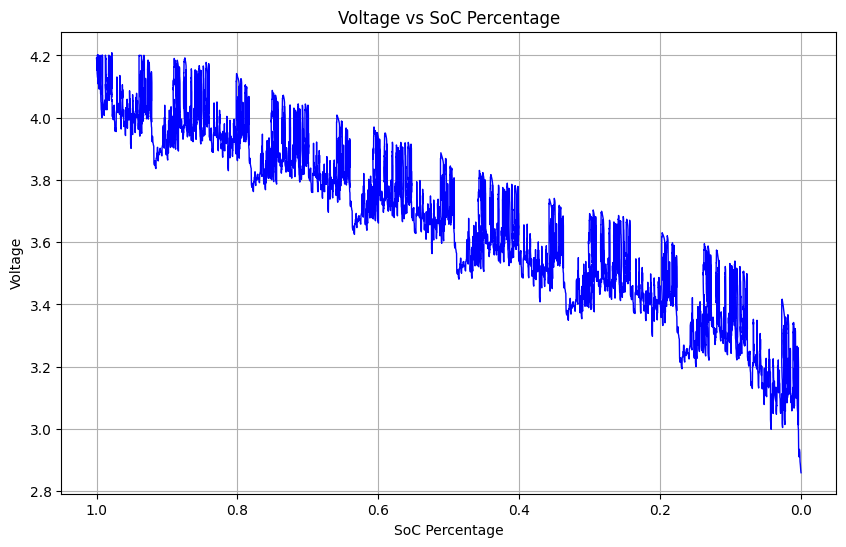

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_train1['SoC Percentage'], df_train1['Voltage'], color='blue', alpha=1, linewidth=1)  # Set line width
plt.title('Voltage vs SoC Percentage')
plt.xlabel('SoC Percentage')
plt.ylabel('Voltage')
plt.grid(True)

# Invert the x-axis to put zero on the right
plt.gca().invert_xaxis()

plt.show()

In [ ]:
df_sampled = df_train1.iloc[::100, :]

**Explanation:**
- `df_train1.iloc` is used for selecting rows and columns by index.
- `::100` is **Python slicing notation**, which means **"select every 100th row"** from the DataFrame.
- `:` indicates that **all columns** should be included.

**Effect:**  
This creates a new DataFrame, `df_sampled`, which contains **every 100th row** from `df_train1`, effectively **downsampling the dataset**.

In [ ]:
df_sampled.shape

(948, 16)

In [ ]:
# Extracting 'Time Stamp' and 'SoC Percentage' as numpy arrary
x_val = df_sampled['Time Stamp'].to_numpy()
y_val = df_sampled['SoC Percentage'].to_numpy()

In [ ]:
print(x_val.shape)
print(y_val.shape)

(948,)
(948,)


In [ ]:
# Define x-tick values (e.g., every 20th point in the downsampled data)
num_ticks = 20
x_ticks_val = np.linspace(0, len(x_val)-1, num = num_ticks, dtype = int)

In [ ]:
x_ticks_val

array([  0,  49,  99, 149, 199, 249, 299, 348, 398, 448, 498, 548, 598,
       647, 697, 747, 797, 847, 897, 947])

Explanation of x_tick_val:

**Breakdown:**
1. **`num_ticks = 20`**  
   - Defines the number of x-axis ticks to display on the plot.

2. **`np.linspace(0, len(x_val)-1, num=num_ticks, dtype=int)`**  
   - `np.linspace(start, stop, num, dtype=int)`:  
     - Generates `num_ticks` evenly spaced integers between `0` and `len(x_val)-1`.
     - Ensures that the x-ticks cover the full range of `x_val`.

**Effect:**
This creates an array of **20 evenly spaced indices** from `x_val`, which can be used as **tick positions** for better readability in a plot.



## Plotting SoC vs Time using seaborn

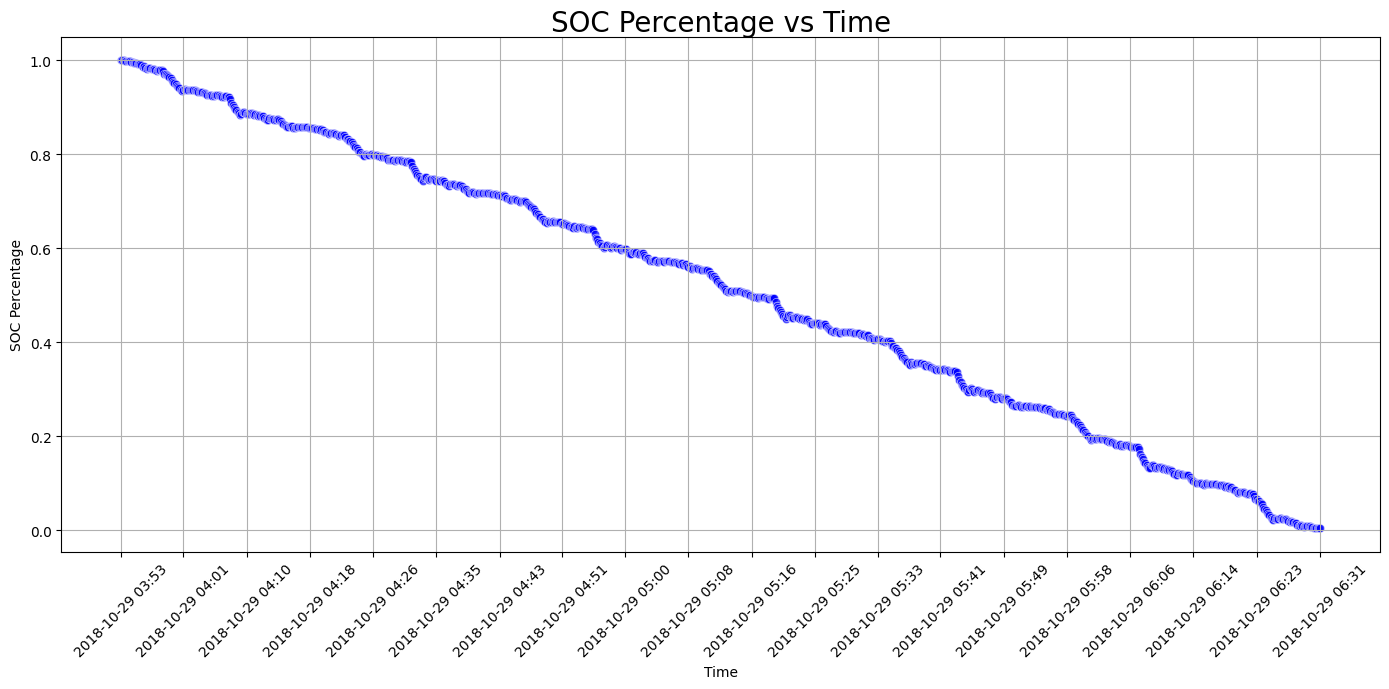

In [ ]:
# plotting SoC Percentage Vs Time using Seaborn
plt.figure(figsize = (14,7)) # defining plot size 14 length x 7 height

sns.scatterplot(x = x_val, y=y_val, color ='blue', alpha = 0.7)

plt.xlabel('Time')
plt.ylabel('SOC Percentage')
#plt.title('SOC Percentage vs Time'), fontdict={'fontsize':20}, 'fontweight':3, 'verticalalignment': 'center', 'horizontalalignment': 'center'})
plt.title('SOC Percentage vs Time', fontdict={'fontsize': 20, 'fontweight': 3, 'verticalalignment': 'center', 'horizontalalignment': 'center'})

# customizing x_ticks
plt.xticks(ticks = x_val[x_ticks_val], labels = [pd.to_datetime(label).strftime('%Y-%m-%d %H:%M') for label  in df_sampled['Time Stamp'].iloc[x_ticks_val]], rotation = 45)

plt.grid(True)
plt.tight_layout()
plt.show()

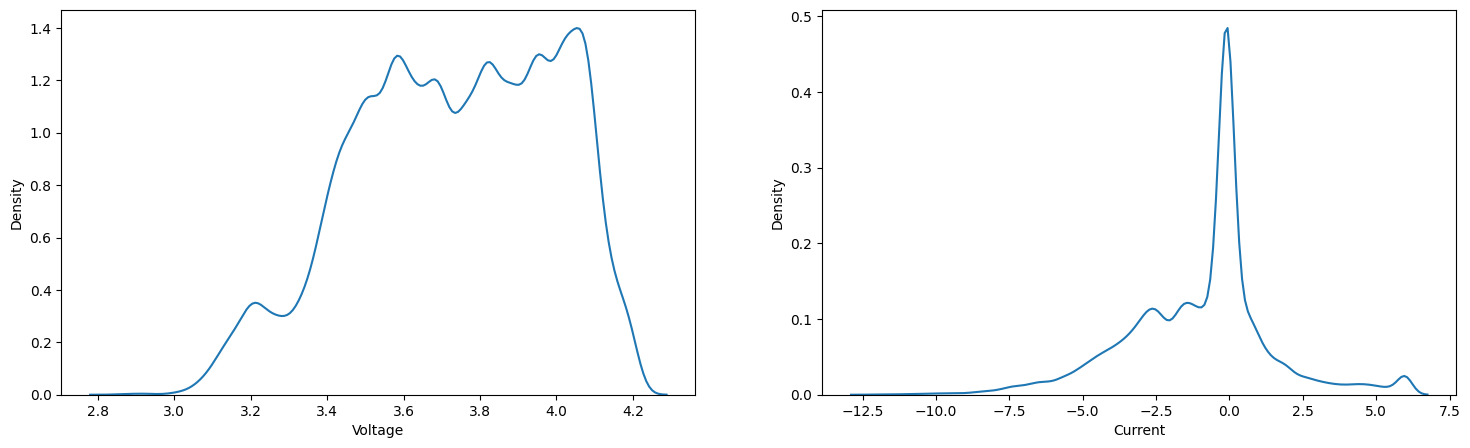

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.kdeplot(data=df_train1, x ="Voltage", ax = axes[0])
sns.kdeplot(data=df_train1, x ="Current", ax = axes[1])
plt.show()

Explanation of the sns.kdeplot Code:
1. **`fig, axes = plt.subplots(1, 2, figsize=(18, 5))`**  
   - Creates a figure with **two subplots** arranged **horizontally** (`1` row, `2` columns).
   - `figsize=(18, 5)` sets the size of the figure (18 units wide and 5 units tall).
   - `axes` is an array of axes objects, one for each subplot.

2. **`sns.kdeplot(data=df_train1, x="Voltage", ax=axes[0])`**  
   - This line plots a **Kernel Density Estimation (KDE)** for the **"Voltage"** column from `df_train1`.
   - The plot is drawn in the first subplot (`axes[0]`).

3. **`sns.kdeplot(data=df_train1, x="Current", ax=axes[1])`**  
   - This line plots a **Kernel Density Estimation (KDE)** for the **"Current"** column from `df_train1`.
   - The plot is drawn in the second subplot (`axes[1]`).

4. **`plt.show()`**  
   - Displays the plots in a single figure.

**Effect:**
- This code produces a side-by-side visualization of the **KDE plots** for both the **Voltage** and **Current** data from `df_train1`.
- **KDE** is a smooth, continuous estimate of the distribution of a dataset, showing where the values of each variable are more concentrated.

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

sc = StandardScaler()

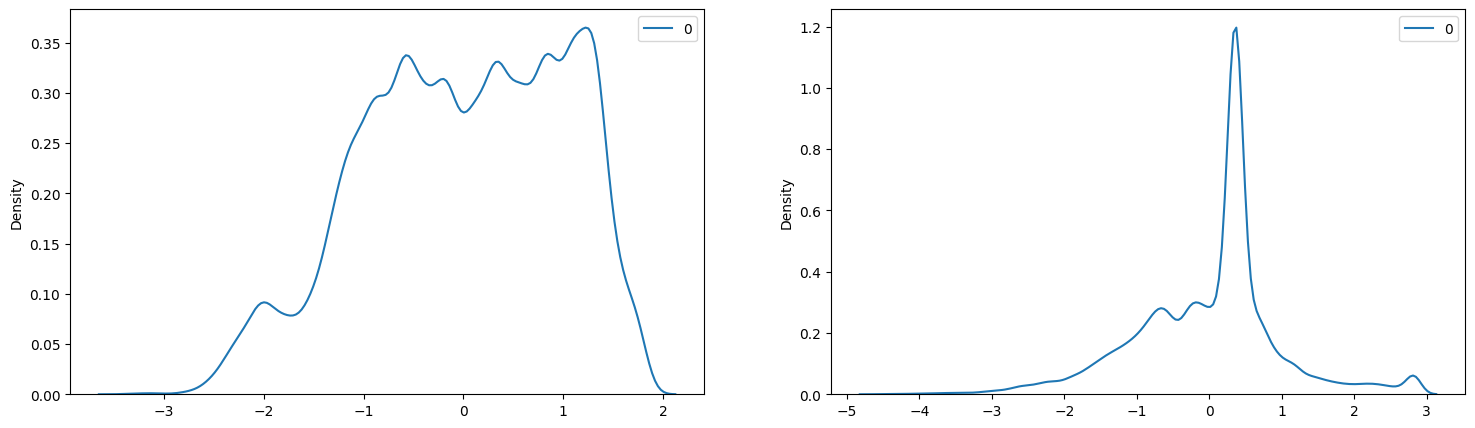

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

x = sc.fit_transform(df_train1["Voltage"].to_numpy().reshape(-1, 1))
x1 = sc.fit_transform(df_train1["Current"].to_numpy().reshape(-1, 1))
sns.kdeplot(data=x, ax = axes[0])
sns.kdeplot(data=x1, ax=axes[1])
plt.show()

The code above creates two **Kernel Density Estimation (KDE)** plots for the **normalized** `Voltage` and `Current` data from `df_train1`.

```python
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
```
- Creates a figure with **two subplots**, arranged **horizontally** (`1` row, `2` columns).
- `figsize=(18, 5)` sets the figure's size (18 units wide and 5 units tall).
- `axes` is a list of axes objects, one for each subplot.

```python
x = sc.fit_transform(df_train1["Voltage"].to_numpy().reshape(-1, 1))
x1 = sc.fit_transform(df_train1["Current"].to_numpy().reshape(-1, 1))
```
- **Normalization/Standardization**:
  - `sc.fit_transform()` applies a **scaler transformation** (most likely `StandardScaler` from `sklearn`) to normalize the data. The `fit_transform()` method **fits** the scaler to the data and then **transforms** it.
  - `df_train1["Voltage"].to_numpy().reshape(-1, 1)` converts the `Voltage` column into a **NumPy array** and reshapes it into a column vector (`-1` means the number of rows is inferred automatically).
  - `x` and `x1` are the **normalized** (standardized) versions of the `Voltage` and `Current` data.

```python
sns.kdeplot(data=x, ax=axes[0])
sns.kdeplot(data=x1, ax=axes[1])
```
- **Kernel Density Estimation (KDE)**:
  - The first `sns.kdeplot` draws the KDE plot for the **normalized** `Voltage` data (`x`), and it will be placed in the first subplot (`axes[0]`).
  - The second `sns.kdeplot` draws the KDE plot for the **normalized** `Current` data (`x1`), and it will be placed in the second subplot (`axes[1]`).

```python
plt.show()
```
- Displays the plots in the same figure.

In [ ]:
df_train1[["Voltage", "Current", "Temperature"]].head()

,Voltage,Current,Temperature
0,4.19088,-0.08173,23.76583
1,4.19054,-0.08939,23.76583
2,4.19037,-0.09195,23.76583
3,4.19037,-0.09195,23.76583
4,4.19037,-0.09195,23.76583


## Data Setup for training ML model

In [ ]:
x = df_train1[["Voltage", "Current", "Temperature"]].to_numpy()
y = df_train1[["SoC Percentage"]].to_numpy()


**features and labels:**

```python
x = df_train1[["Voltage", "Current", "Temperature"]].to_numpy()
```
- This line selects the columns `Voltage`, `Current`, and `Temperature` from the `df_train1` DataFrame.
- `.to_numpy()` converts the selected columns into a **NumPy array**, which is stored in the variable `x`.
  - The resulting `x` will be a 2D array where each row corresponds to a set of values for `Voltage`, `Current`, and `Temperature` for a specific time step or cycle in your dataset.

```python
y = df_train1[["SoC Percentage"]].to_numpy()
```
- This line selects the column `SoC Percentage` from the `df_train1` DataFrame.
- `.to_numpy()` converts the `SoC Percentage` column into a **NumPy array**, which is stored in the variable `y`.
  - The resulting `y` will be a 2D array with a single column containing the state of charge (SoC) percentage for each corresponding row in `x`.

**summary:**
- `x` contains the input features: **Voltage**, **Current**, and **Temperature**.
- `y` contains the target output: **SoC Percentage**.

This is likely the setup for training a **machine learning model** (like a regression model or neural network) where `x` is the feature set (independent variables) and `y` is the target label (dependent variable). The goal is to predict the **SoC Percentage** (`y`) based on the values of **Voltage**, **Current**, and **Temperature** (`x`).

In [ ]:
cycles = []
cycles.append((x, y))

1. **`cycles = []`**:
   - This creates an empty list called `cycles`. The list is intended to store pairs of data (features and target values) for each cycle or observation.

2. **`cycles.append((x, y))`**:
   - This line appends a tuple `(x, y)` to the `cycles` list.
   - `x` represents the feature matrix containing the columns `Voltage`, `Current`, and `Temperature`.
   - `y` represents the target vector containing the `SoC Percentage`.
   - The `append()` method adds this pair of data (`x` and `y`) to the `cycles` list.

After this code is executed, `cycles` will contain a list with a single element, which is a tuple. This tuple consists of the `x` (input features) and `y` (target value) arrays.

If you plan to store data for multiple cycles or observations, you would typically call `append()` multiple times with different data. For example:

```python
cycles.append((x2, y2))  # Add data for the second cycle
cycles.append((x3, y3))  # Add data for the third cycle
# and so on...
```

So, `cycles` will eventually contain multiple tuples, each representing the input-output pair for different cycles or observations.

In [ ]:
cycles[0] # x , y pair
print(cycles[0][0]) # gives x
print(cycles[0][1]) #gives y
print(cycles[0][0][0]) # gives voltage, current, temperature values

[[ 4.19088 -0.08173 23.76583]
 [ 4.19054 -0.08939 23.76583]
 [ 4.19037 -0.09195 23.76583]
 ...
 [ 2.86179 -9.93796 24.39678]
 [ 2.85977 -9.94562 24.39678]
 [ 2.85926 -9.95073 24.39678]]
[[1.00000000e+00]
 [1.00000000e+00]
 [9.99996139e-01]
 ...
 [2.12333897e-04]
 [1.08097257e-04]
 [0.00000000e+00]]
[ 4.19088 -0.08173 23.76583]


Here's what each of the lines does:

```python
print(cycles[0][0])  # gives x
```
This prints the first element of the tuple `x`, which contains the **Voltage**, **Current**, and **Temperature** values (features) from your dataframe `df_train1`. So, this will show the 2D array with these features.

```python
print(cycles[0][1])  # gives y
```
This prints the second element of the tuple `y`, which contains the **SoC Percentage** (target) values. It will show the 2D array with the corresponding target values for each sample.

```python
print(cycles[0][0][0])  # gives voltage, current, temperature values
```
This prints the first row of the array `x` from the tuple. The first row contains the voltage, current, and temperature values for the first observation. It will show a 1D array like:
```
[Voltage_value, Current_value, Temperature_value]
```

# Data Cleaning
---

In [ ]:
Main_Path="/content/drive/MyDrive/Datasets/LG_HG2/"

## Get discharge data for whole cycle

In [ ]:
def get_discharge_whole_cycle(
    train_files: object,
    test_files: object,
    output_capacity: bool = False,
    scale_test: bool = False,
    output_time: bool = False
) -> tuple:
    """
    This function returns the train and test data for all cycles
    according to the file paths provided
    and scales according to the user input.
    """
    train = _get_data(train_files, output_capacity, output_time)
    test = _get_data(test_files, output_capacity, output_time)
    train, test = _scale_x(train, test, scale_test=scale_test)
    return (train, test)

Explanation:
1. **Function Signature**:
   - `train_files: object`, `test_files: object`: These are placeholders for the input parameters, and `object` represents any Python object.
   - `output_capacity: bool = False`: Specifies that `output_capacity` is a boolean with a default value of `False`.
   - `scale_test: bool = False`: Similarly, the `scale_test` argument is also a boolean with a default value of `False`.
   - `output_time: bool = False`: Same for `output_time`.

2. **Return Type**: `-> tuple`: The function is expected to return a tuple, which consists of the `train` and `test` datasets.

## Get data one cycle after cleaning csv files

In [ ]:
# Main_Path="/content/drive/MyDrive/Datasets/LG_HG2/"
def _get_data(names: object,
              output_capacity: bool = False,
              output_time: bool = False) -> list:
    """
    Returns a list of (x, y) tuples for every file path.
    """
    cycles = []
    for name in names:
        # print(f"Extracting for {name}...")
        cycle = pd.read_csv(Main_Path + name + ".csv", skiprows=30)
        cycle.columns = [
            "Time Stamp",
            "Step",
            "Status",
            "Prog Time",
            "Step Time",
            "Cycle",
            "Cycle Level",
            "Procedure",
            "Voltage",
            "Current",
            "Temperature",
            "Capacity",
            "WhAccu",
            "Cnt",
            "Empty",
        ]
        cycle = cycle[(cycle["Status"] == "TABLE") | (cycle["Status"] == "DCH")]

        max_discharge = abs(min(cycle["Capacity"]))
        cycle["SoC Capacity"] = max_discharge + cycle["Capacity"]
        cycle["SoC Percentage"] = cycle["SoC Capacity"] / max(cycle["SoC Capacity"])
        x = cycle[["Voltage", "Current", "Temperature"]].to_numpy()

        if output_time:
            cycle["Prog Time"] = cycle["Prog Time"].apply(_time_string_to_seconds)
            cycle["Time in Seconds"] = cycle["Prog Time"] - cycle["Prog Time"][0]

        if output_capacity:
            if output_time:
                y = cycle[["SoC Capacity", "Time in Seconds"]].to_numpy()
            else:
                y = cycle[["SoC Capacity"]].to_numpy()
        else:
            if output_time:
                y = cycle[["SoC Percentage", "Time in Seconds"]].to_numpy()
            else:
                y = cycle[["SoC Percentage"]].to_numpy()

        if np.isnan(np.min(x)) or np.isnan(np.min(y)):
            print(f"There is a NaN in cycle {name}, removing row")
            x = x[~np.isnan(x).any(axis=1)]
            y = y[~np.isnan(y).any(axis=1)].reshape(-1, y.shape[1])

        cycles.append((x, y))  # Appending as a tuple (x, y)

    return cycles


Explanation:
- The function `_get_data` reads CSV files, processes them to extract relevant columns (`Voltage`, `Current`, `Temperature`, etc.), computes `SoC Percentage` or `SoC Capacity`, and appends `x` (features) and `y` (labels) as a tuple to the `cycles` list.
- It also handles `NaN` values by removing rows containing `NaN`.

## MinMaxScaler(scikit learn)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def _scale_x(train: tuple,
             test: tuple,
             scale_test: bool= False) -> tuple:

    # Flatten train data to fit MinMaxScaler
    train_features = np.concatenate([cycle[0] for cycle in train], axis = 0)

    # Initialize the scaler
    scaler = MinMaxScaler()

    # Fit and transform the train data
    scaler.fit(train_features)

    # Create new lists for transformed train and test data
    scaled_train = []
    scaled_test = []

    # Scaling the training data
    for i in range(len(train)):
        scaled_cycle = (scaler.transform(train[i][0]), train[i][1])
        scaled_train.append(scaled_cycle)

    # Scaling the test data if specified
    if scale_test:
        for i in range(len(test)):
            scaled_cycle = (scaler.transform(test[i][0]), test[i][1])
            scaled_test.append(scaled_cycle)
    else:
        scaled_test = test  # If not scaling test, keep the original test data without scaling

    print("Done")
    return scaled_train, scaled_test


Explanation:
- **Train Scaling:** You concatenate all the feature sets from the training data (`cycle[0]` for each cycle) and use `MinMaxScaler` to fit and transform them. The transformed data is stored back in the `scaled_train` list.
- **Test Scaling:** If `scale_test` is `True`, you scale the test data (`test[i][0]`) using the same scaler and keep the corresponding labels (`test[i][1]`). If not, the original test data is returned without scaling.


# Train test split
---

## Converting all times to seconds

In [ ]:
from datetime import timedelta

def _time_string_to_seconds(input_string: str) -> float:
    time_parts = input_string.split(":")
    second_parts = time_parts[2].split(".")
    return timedelta(
        hours = int(time_parts[0]),
        minutes = int(time_parts[1]),
        seconds = int(second_parts[0]),
        microseconds = int(second_parts[1]),
    ).total_seconds()


Explanation:
- The input string `input_string` is assumed to be in the format `HH:MM:SS.sss` (for example, `01:23:45.678`).
- The string is first split by the `:` character to separate hours, minutes, and seconds.
- The seconds part is further split by `.` to separate the integer seconds from the fractional microseconds.
- The `timedelta` is used to create a time difference object, and then `total_seconds()` returns the total time in seconds as a float.

## Getting multiple discharge steps

In [ ]:
import numpy as np
from typing import List, Tuple

def get_discharge_multiple_steps(
    cycles: List[Tuple[np.ndarray, np.ndarray]], steps: int
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Splits the given cycle data into multiple time steps for training and testing.

    Args:
        cycles: A list of two tuples, where:
                - cycles[0] (training data) is a tuple of (features, targets)
                - cycles[1] (testing data) is a tuple of (features, targets)
        steps: Number of time steps for sequence modeling.

    Returns:
        Tuple of four NumPy arrays: (train_x, train_y, test_x, test_y)
    """
    train_x, train_y = _split_to_multiple_step(cycles[0], steps)
    test_x, test_y = _split_to_multiple_step(cycles[1], steps)

    return train_x, train_y, test_x, test_y



- **Function Name**: `get_discharge_multiple_steps`
- **Parameters**:
  - `cycles`: Object containing training and testing cycles data.
  - `steps`: Integer defining the number of steps for splitting.
- **Functionality**:
  1. Splits training cycle data (`cycles[0]`) into multiple steps using `split_to_multiple_step`.
  2. Splits testing cycle data (`cycles[1]`) into multiple steps using `_split_to_multiple_step`.
  3. Returns the split data in the form of `(train_x, train_y, test_x, test_y)`:
     - `train_x`: Features for training data.
     - `train_y`: Target values for training data.
     - `test_x`: Features for testing data.
     - `test_y`: Target values for testing data.

### What is the use of multiple discharge steps and how does it differ from batching?

The primary difference between **splitting data into multiple steps** (like in your function `get_discharge_multiple_steps`) and **batching data for training** lies in the organization of data and the specific purpose behind each process. Here's a comparison:

 1. **Purpose and Data Structure**:
   - **Splitting into Multiple Steps**:
     - It is used for creating **time-series windows** or **sequences** from sequential data, such as battery discharge cycles.
     - Each "step" is essentially a **sub-sequence** or time window of data that preserves the temporal relationships between consecutive observations.
     - This is useful for models like **Recurrent Neural Networks (RNNs)**, **LSTMs**, or other time-series models where the model needs to learn from sequences of data.

   - **Batching Data for Training**:
     - Batching is the process of grouping the data into **mini-batches** for efficient training.
     - Batches are typically formed randomly (or using techniques like shuffling), and they are designed to fit into the memory and training process of the model.
     - Batching is a **training technique** used to optimize the learning process, and each batch is used to calculate the gradient and update model weights.

 2. **Data Split**:
   - **Splitting into Multiple Steps**:
     - Involves dividing continuous data into **overlapping or non-overlapping windows** of fixed length (e.g., past N timesteps).
     - Each step might have its own **input (features)** and **output (labels)**, depending on the sequence being modeled.
   
   - **Batching Data for Training**:
     - It usually involves splitting the entire dataset into **smaller subsets** (batches), where each batch contains a fixed number of data points, irrespective of their temporal relationships.
     - This step doesn't necessarily preserve the **sequential nature** of the data, as batches can be formed randomly.

3. **Model Input**:
   - **Splitting into Multiple Steps**:
     - The data is transformed into sequences, which will be used as **model inputs** for learning temporal dependencies.
     - For example, for battery SOC prediction, each sequence might contain a set of past voltage, current, and temperature readings.
   
   - **Batching Data for Training**:
     - The data is grouped into batches, and each batch is used to update the model parameters during the **training loop**.
     - The primary goal of batching is to ensure **efficient training** rather than modeling temporal dependencies.

4. **Usage in Models**:
   - **Splitting into Multiple Steps**:  
     - This is important for models that rely on sequences (like RNNs, LSTMs, etc.) to learn from the **temporal order** of data.
   
   - **Batching Data for Training**:
     - Batching is more focused on optimizing the training process (by handling large datasets in smaller chunks). It's used with all kinds of models (including feed-forward networks) to improve convergence and generalization.

Conclusion:
While **splitting into multiple steps** organizes the data for models that need to learn from **temporal sequences**, **batching** is a technique used to **optimize the training process** by splitting data into smaller chunks. In some cases, **sequences can be batched** for training, where each batch contains several time windows. So, **splitting into multiple steps** may be one part of **batching** in a sequence-based model, but batching serves a broader purpose in machine learning optimization.

## Split to multiple steps

In [ ]:
import numpy as np
from typing import List, Tuple

def _split_to_multiple_step(
    cycles: List[Tuple[np.ndarray, np.ndarray]], steps: int
)->Tuple[np.ndarray, np.ndarray]:

    x_length = cycles[0][0].shape[1]  # Number of features (Voltage, Current, Temperature)
    y_length = cycles[0][1].shape[1]  # Number of target variables (SoC, Capacity, etc.)

    x = []  # Using list first for efficient appending
    y = []

    for cycle in cycles:
        for i in range(0, len(cycle[0]) - steps, steps):
            next_x = np.array(cycle[0][i: i + steps]).reshape(1, steps, x_length)
            next_y = np.array(cycle[1][i: i + steps]).reshape(1, steps, y_length)
            x.append(next_x)
            y.append(next_y)

    # Convert lists to numpy arrays after all appending is done
    x = np.concatenate(x, axis=0)
    y = np.concatenate(y, axis=0)

    return x, y



- **Purpose**: Split cycles into multiple steps for time-series model training.
  
- **Inputs**:
  - `cycles`: A list of (x, y) pairs, where `x` is the feature data and `y` is the target data.
  - `steps`: Number of time steps for each input-output sequence.

- **Key Actions**:
  1. **Calculate Data Lengths**: `x_length` (features) and `y_length` (target variables) are determined from the first cycle's shape.
  2. **Initialize Lists**: `x` and `y` lists are used to store split sequences.
  3. **Loop Over Cycles**: For each cycle, split the data into overlapping windows of length `steps`.
  4. **Reshape Data**: Each window is reshaped to `(1, steps, x_length)` for `x` and `(1, steps, y_length)` for `y`.
  5. **Append Data**: Each reshaped sequence is added to `x` and `y`.
  6. **Convert to Numpy Arrays**: The lists are converted to numpy arrays after the loop.

- **Output**: Returns `x` and `y` as numpy arrays containing all the split sequences for training.

## To keep only label

In [ ]:
import numpy as np

def keep_only_y_end(y: np.ndarray,
                    step: int,
                    is_stateful: bool=False)->np.ndarray:
    if is_stateful:
        return y[:, :, ::step]
    else:
        return y[:, ::step]

Function Explanation: `keep_only_y_end`

- **Purpose**: This function is used to extract specific parts of the target (`y`) data based on the provided `step` size and whether the model is stateful or not.

- **Inputs**:
  - `y`: The target data (e.g., SoC, Capacity) of shape `(num_samples, num_steps, num_features)`.
  - `step`: The step size, indicating the interval at which to select data points.
  - `is_stateful`: A boolean flag (default is `False`) indicating whether the model is stateful or not.

- **Key Actions**:
  1. **Stateful Model** (`is_stateful=True`): Selects data points starting from the last element of each sequence, then steps backward at intervals defined by `step` using the slice `::step`. The result will have the last elements for each sequence.
  2. **Non-stateful Model** (`is_stateful=False`): Selects every `step`-th element along the time dimension. It effectively reduces the resolution of the target sequence.

- **Output**: Returns a reduced version of `y` with the selected time steps, either starting from the last elements for stateful models or every `step`-th element for non-stateful models.

## Set up training data, test data and other parameters

In [ ]:
train_files = [
    #'0degC/589_LA92',
    #  '0degC/590_Mixed6',
    #  '0degC/590_Mixed8',
    #  '0degC/589_Mixed1',
    #  '0degC/589_US06',
    #  '10degC/567_Mixed1',
    #  '10degC/571_Mixed8',
    #  '10degC/571_Mixed4',
    #  '10degC/571_Mixed6',
    #  '10degC/567_Mixed2',
    #     '25degC/551_Mixed1',
    #     '25degC/551_Mixed2',
    '25degC/551_UDDS',
    #     '25degC/552_Mixed3',
    #     '25degC/552_Mixed8'
    "0degC/589_LA92",
    "0degC/589_UDDS",
    "0degC/589_Mixed1",
    "0degC/589_Mixed2",
    "0degC/590_Mixed4",
    "0degC/590_Mixed5",
    "0degC/590_Mixed6",
    "0degC/590_Mixed8",
    "10degC/567_US06",
    "10degC/571_Mixed7",
    "10degC/567_Mixed1",
    "10degC/567_Mixed2",
    "10degC/571_Mixed4",
    "10degC/571_Mixed5",
    "10degC/571_Mixed6",
    "10degC/571_Mixed8",
    "25degC/551_Mixed1",
    "25degC/551_Mixed2",
    #'25degC/552_Mixed3',
    "25degC/551_LA92",
    "25degC/551_UDDS",
    "25degC/552_Mixed4",
    "25degC/552_Mixed5",
    "25degC/552_Mixed6",
    "25degC/552_Mixed8",
]
test_files = [
    #     "0degC/589_UDDS",
    #     "0degC/589_US06",
    #     "0degC/590_Mixed7",
    #     "10degC/582_LA92",
    #     "10degC/567_US06",
    #     "10degC/571_Mixed7",
    #     "25degC/551_LA92",
    #     "25degC/551_US06",
    #     "25degC/552_Mixed7",

    "0degC/589_US06",
    "0degC/590_Mixed7",
    "10degC/582_LA92",
    "10degC/576_UDDS",


    "25degC/551_US06",
    "25degC/552_Mixed7",
]
steps = 300
# stateful_config = True


We are defining lists of training and testing files for battery cycle data, for machine learning model training and evaluation.

**Key Points**
1. **`train_files`**:
   - Contains filenames of battery discharge cycles at different temperatures (`0°C`, `10°C`, `25°C`).
   - Many filenames are commented out.
   - Includes various drive cycles (`LA92`, `UDDS`, `US06`) and mixed profiles (`Mixed1`, `Mixed2`, etc.).

2. **`test_files`**:
   - Includes a smaller selection of files across the same temperature ranges.
   - Some test files are commented out.

3. **`steps = 300`**:
   - Likely defines the number of time steps for sequence modeling, possibly used for LSTM or other time-series models.

4. **`stateful_config = True`** (commented out):
   - Possibly a flag for stateful training (e.g., in RNNs or LSTMs).

**Next Steps**
- If we are using this in a data pipeline, we should ensure that:
  - File paths match our dataset's structure.
  - Training and testing sets do not overlap.
  - we properly load and preprocess the data before passing it to the model.

In [ ]:
%%time
cycles = get_discharge_whole_cycle(train_files, test_files, output_capacity=False, scale_test=True)

There is a NaN in cycle 10degC/582_LA92, removing row
Done
CPU times: user 7.37 s, sys: 1.08 s, total: 8.45 s
Wall time: 24.5 s


our code snippet is executing the `get_discharge_whole_cycle` function with training and test files while measuring execution time using `%%time`. Here’s what each argument likely does:

**Understanding the Code**
- **`%%time`**:
  - A Jupyter Notebook magic command that measures the execution time of the entire cell.
  
- **`get_discharge_whole_cycle(train_files, test_files, output_capacity=False, scale_test=True)`**:
  - `train_files`: List of training battery cycle data files.
  - `test_files`: List of test battery cycle data files.
  - `output_capacity=False`: Likely disables capacity-related outputs (e.g., avoiding `Ah` capacity calculations).
  - `scale_test=True`: Possibly applies scaling/normalization to test data to match training data distribution.

**Expected Output**
- The function likely returns `cycles`, which may contain:
  - **Processed time-series data** (e.g., voltage, current, temperature, SoC).
  - **Separate train and test data** in a structured format.
  - **Scaling applied** to test data if enabled.

**Next Steps**
- If you need to check the structure of `cycles`, try:
  ```python
  type(cycles)
  len(cycles)
  print(cycles.keys())  # If it returns a dictionary
  ```
- If using an LSTM or deep learning model, ensure the sequence data is correctly formatted.

In [ ]:
type(cycles)

tuple

In [ ]:
len(cycles)

2

In [ ]:
print(
    f"First element of cycles has {len(cycles[0])} files and they belong to training data.\nSecond element of cycles has {len(cycles[1])} files and they belong to test data."
)

print("Train/Test %d" % len(cycles))
print("x/y :%d" % len(cycles[0][0]))
print("time_steps: %d" % len(cycles[0][0][0]))
print("x features: %d" % len(cycles[0][0][0][0]))

First element of cycles has 25 files and they belong to training data.
Second element of cycles has 6 files and they belong to test data.
Train/Test 2
x/y :2
time_steps: 153644
x features: 3


Breakdown of the Code Output
1. **Train/Test Split:**  
   - `cycles[0]` → Training data (e.g., `len(cycles[0])` files).  
   - `cycles[1]` → Test data (e.g., `len(cycles}[1])` files).  

2. **Overall Structure:**  
   - `len(cycles) = 2` (train & test).  

3. **Data Format:**  
   - `len(cycles[0][0]) = 2` (input `x`, target `y`).  
   - `len(cycles[0][0][0]) = steps` (e.g., `300`).  
   - `len(cycles[0][0][0][0]) = num_features` (e.g., `3`).  


## Split data into train and test

In [ ]:
# new
train_x, train_y, test_x, test_y = get_discharge_multiple_steps(cycles, steps)


1. **Function Call:** `get_discharge_multiple_steps(cycles, steps)`  
2. **Outputs:**  
   - `train_x, train_y` → Training data (features & targets).  
   - `test_x, test_y` → Test data (features & targets).  
3. **Processing:**  
   - Splits `cycles` into multiple time steps (`steps`).  
   - Converts into structured training & testing sets.  
4. **Purpose:**  
   - Prepares data for sequence-based models (e.g., LSTMs).

In [ ]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((6426, 300, 3), (6426, 300, 1), (1372, 300, 3), (1372, 300, 1))

**Shape Description**  
1. **`train_x.shape`**:  
   - Represents the dimensions of the training features.
   - Format: `(samples, time_steps, features)`  
   
2. **`train_y.shape`**:  
   - Represents the dimensions of the training targets.
   - Format: `(samples, time_steps, targets)`  

3. **`test_x.shape`**:  
   - Represents the dimensions of the test features.
   - Format: `(samples, time_steps, features)`  

4. **`test_y.shape`**:  
   - Represents the dimensions of the test targets.
   - Format: `(samples, time_steps, targets)`

In [ ]:
# use helper function keep_only_y_end
train_y = keep_only_y_end(train_y, steps)
test_y = keep_only_y_end(test_y, steps)

**`keep_only_y_end` Function**  
1. **Purpose**:  
   - Reduces the target variables (`y`) to keep only the last step for each sequence.

2. **Arguments**:  
   - `train_y`: Training target data.
   - `test_y`: Test target data.
   - `steps`: Number of steps per sequence.

3. **Effect**:  
   - For each sequence in `train_y` and `test_y`, keeps only the last step (using slicing with the `steps` interval).
   - If `is_stateful` is `True`, it selects the last step at each `steps` interval; otherwise, it selects only the last step across all sequences.

4. **Result**:  
   - Modifies `train_y` and `test_y` to keep only the last target variable in each sequence.

# Training the Model

## Importing tensorflow-keras models

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, InputLayer
from tensorflow.keras.optimizers import SGD, Adam
# from keras.utils import np_unils
from keras.layers import LSTM, BatchNormalization, RepeatVector, TimeDistributed, Masking, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint, LambdaCallback

**Imports Breakdown**:

1. **TensorFlow and Keras Imports**:
   - `import tensorflow as tf`: Imports the core TensorFlow library.
   - `from tensorflow import keras`: Imports Keras from TensorFlow, making it easier to define models and layers.
   - `from tensorflow.keras import layers`: Imports layer components from Keras, enabling layer creation for deep learning models.

2. **Keras Model and Layers**:
   - `from keras.models import Sequential`: Imports the `Sequential` model, where layers are stacked linearly.
   - `from keras.layers import Dense, Dropout, Activation, InputLayer`:
     - `Dense`: Fully connected layer.
     - `Dropout`: Regularization technique to reduce overfitting.
     - `Activation`: Defines activation functions (e.g., ReLU, Sigmoid).
     - `InputLayer`: Layer to define the input shape to the model.
   
3. **Optimizers**:
   - `from tensorflow.keras.optimizers import SGD, Adam`:
     - `SGD`: Stochastic Gradient Descent, commonly used optimizer.
     - `Adam`: Adaptive Moment Estimation, an adaptive optimizer often used for deep learning models.

4. **Additional Layers**:
   - `from keras.layers import LSTM, BatchNormalization, RepeatVector, TimeDistributed, Masking, Bidirectional`:
     - `LSTM`: Long Short-Term Memory (RNN) layer used for sequence modeling.
     - `BatchNormalization`: Normalization layer to improve training speed and stability.
     - `RepeatVector`: Layer to repeat input sequence for decoder in sequence-to-sequence models.
     - `TimeDistributed`: Applies a layer to each time step in a sequence.
     - `Masking`: Helps in ignoring padding values during training.
     - `Bidirectional`: Wrapper for making RNN layers bidirectional.
   
5. **Callbacks**:
   - `from keras.callbacks import EarlyStopping, ModelCheckpoint, LambdaCallback`:
     - `EarlyStopping`: Stops training early if the model performance doesn’t improve.
     - `ModelCheckpoint`: Saves model weights during training at checkpoints.
     - `LambdaCallback`: Allows custom callback functions at certain training points (e.g., after every epoch).

**Summary**:  
This set of imports includes essential modules for creating deep learning models using Keras with TensorFlow backend. It supports various neural network architectures like feed-forward, LSTM, and RNNs, along with optimization techniques and regularization tools.

In [ ]:
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Explanation:
- `tf.config.list_physical_devices('GPU')`: This command lists all the physical devices recognized by TensorFlow as GPUs.
- If you have a compatible GPU and TensorFlow is correctly set up to use it, it will return a list of available GPU devices. Otherwise, it will return an empty list.

This will help us confirm whether TensorFlow is able to access our GPU.

In [ ]:
from tensorflow.python.client import device_lib

def get_gpu_name():
    local_devices = device_lib.list_local_devices()
    for device in local_devices:
        if device.device_type == 'GPU':
            return device.physical_device_desc

gpu_name = get_gpu_name()
print(gpu_name)


device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5


Explanation:
- `device_lib.list_local_devices()` returns a list of devices available on your machine.
- It checks for devices of type `'GPU'` and returns the `physical_device_desc`, which contains detailed information, including the GPU name.
  
This will print the name and description of our available GPU(s).

In [ ]:
cst = pytz.timezone("Asia/Shanghai")
current_time_cst = datetime.now(cst)
print("Current Time in CST: ", current_time_cst.strftime("%Y-%m-%d %H:%M:%S"))

Current Time in CST:  2025-03-08 14:46:04


Explanation:
- The `pytz.timezone("Asia/Shanghai")` is used to set the timezone to Beijing.
- `datetime.now(beijing_tz)` gets the current time in the Beijing timezone.


## Experiment defination

[Module: tf.keras.activations](https://www.tensorflow.org/api_docs/python/tf/keras/activations)

For regression problems we can use one of several loss functions:
▪️ MSE
▪️ MAE
▪️ Huber loss

**Mean Squared Error (MSE):**
The MSE is used to measure the average squared difference between the predicted values and the actual values. The formula is:

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

Where:
- $n$ is the number of data points.
- $y_i$ is the true value for the $i$-th data point.
- $\hat{y}_i$ is the predicted value for the $i$-th data point.

**Mean Absolute Error (MAE):**
The MAE measures the average of the absolute differences between the predicted values and the actual values. The formula is:

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$

Where:
- $n$ is the number of data points.
- $y_i$ is the true value for the $i$-th data point.
- $\hat{y}_i$ is the predicted value for the $i$-th data point.

**Huber Loss:**
The Huber loss is less sensitive to outliers than MSE and combines both squared loss and absolute loss. It is defined as:

$$
\text{Huber Loss}(y, \hat{y}) =
\begin{cases}
\frac{1}{2} (y - \hat{y})^2, & \text{for } |y - \hat{y}| \leq \delta \\
\delta |y - \hat{y}| - \frac{1}{2} \delta^2, & \text{for } |y - \hat{y}| > \delta
\end{cases}
$$

Where:
- $\delta$ is a threshold (usually a small positive constant like 1.0).
- $y$ is the true value.
- $\hat{y}$ is the predicted value.

Key Differences:
- **MSE** penalizes large errors more heavily due to the squaring of the differences.
- **MAE** treats all errors equally but is less sensitive to large errors (outliers).
- **Huber Loss** combines both MSE and MAE, making it more robust to outliers, as it switches between the two depending on the size of the error.



In [ ]:
'''
# Define the experiment
EXPERIMENT = "Bi-LSTM_SOC_percentage_lg_positive_temp_300_mixed_cycle_test"

experiment_name = EXPERIMENT+ " in: "  + datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"We are performing: {experiment_name}")

# Define the optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)

# Define the model
model = Sequential()

# Input layer
model.add(InputLayer(input_shape=(train_x.shape[1], train_x.shape[2])))

# FOUR HIDDEN LAYERS
# First Bidirectional LSTM layer
model.add(Bidirectional(LSTM(64, activation = "selu", return_sequences = False))) # Scaled Exponential Linear Unit (SELU)

# Dense layers for further learning and transformations
model.add(Dense(256, activation = "selu"))
model.add(Dense(126, activation = "selu"))
model.add(Dense(64, activation = "selu"))

# output layer
model.add(Dense(1, activation = "linear"))
model.summary()
model.compile(
    optimizer = opt,
    loss = "huber",
    metrics = ["mse", "mae", "mape", tf.keras.metrics.RootMeanSquaredError(name="rmse")],
)

es = EarlyStopping(monitor="val_loss", patience=50)
#es = EarlyStopping(monitor="val_loss", patience=50)

mc = ModelCheckpoint(
    "/Machine Learning/Time_series_forecasting/Bi-LSTM_LG/Results/trained_model/%s_best.keras" % experiment_name,
    save_best_only = True,
    moniter = "val_loss"
)
'''


'\n# Define the experiment\nEXPERIMENT = "Bi-LSTM_SOC_percentage_lg_positive_temp_300_mixed_cycle_test"\n\nexperiment_name = EXPERIMENT+ " in: "  + datetime.now().strftime("%Y-%m-%d %H:%M:%S") \nprint(f"We are performing: {experiment_name}")\n\n# Define the optimizer\nopt = tf.keras.optimizers.Adam(learning_rate=0.00001)\n\n# Define the model\nmodel = Sequential()\n\n# Input layer\nmodel.add(InputLayer(input_shape=(train_x.shape[1], train_x.shape[2])))\n\n# FOUR HIDDEN LAYERS\n# First Bidirectional LSTM layer\nmodel.add(Bidirectional(LSTM(64, activation = "selu", return_sequences = False))) # Scaled Exponential Linear Unit (SELU)\n\n# Dense layers for further learning and transformations\nmodel.add(Dense(256, activation = "selu"))\nmodel.add(Dense(126, activation = "selu"))\nmodel.add(Dense(64, activation = "selu"))\n\n# output layer\nmodel.add(Dense(1, activation = "linear"))\nmodel.summary()\nmodel.compile(\n    optimizer = opt,\n    loss = "huber",\n    metrics = ["mse", "mae", "map

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, InputLayer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from datetime import datetime

# Define experiment name
EXPERIMENT = "bilstm_soc_percentage_lg_positive_temp_300_steps_mixed_cycle_test"
experiment_name = datetime.now().strftime("%Y-%m-%d-%H-%M-%S") + "_" + EXPERIMENT

print(f"We are performing: {experiment_name}")

# Define optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)

# Define the model
model = Sequential()

# Input layer (shape should match train_x dimensions)
model.add(InputLayer(input_shape=(train_x.shape[1], train_x.shape[2])))

# First Bidirectional LSTM layer
model.add(Bidirectional(LSTM(64, activation="selu", return_sequences=False)))

# Dense layers for further learning and transformations
model.add(Dense(256, activation="selu"))
model.add(Dense(128, activation="selu"))
model.add(Dense(64, activation="selu"))

# Output layer
model.add(Dense(1, activation="linear"))

# Print model summary to check architecture
model.summary()

# Compile the model
model.compile(
    optimizer=opt,
    loss="huber",
    metrics=["mse", "mae", "mape", tf.keras.metrics.RootMeanSquaredError(name="rmse")]
)

# Define early stopping and model checkpoint callbacks
es = EarlyStopping(monitor="val_loss", patience=50)
mc = ModelCheckpoint(
   "/kaggle/working/Results/trained_model/%s_best.keras" % experiment_name,
    save_best_only=True,
    monitor="val_loss",
)


We are performing: 2025-03-08-06-46-04_bilstm_soc_percentage_lg_positive_temp_300_steps_mixed_cycle_test


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 128)                 │          34,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 109,057 (426.00 KB)

 Trainable params: 109,057 (426.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
%%time
history = model.fit(train_x, train_y,
                   epochs = 120,
                   batch_size = 32,
                   verbose = 1,
                   validation_split = 0.2,
                    callbacks = [mc, es]
                   )

Epoch 1/120
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - loss: 0.0756 - mae: 0.3037 - mape: 168.3981 - mse: 0.1517 - rmse: 0.3791 - val_loss: 0.0109 - val_mae: 0.1222 - val_mape: 85.2050 - val_mse: 0.0218 - val_rmse: 0.1476
Epoch 2/120
161/161 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - loss: 0.0083 - mae: 0.1025 - mape: 90.9085 - mse: 0.0167 - rmse: 0.1283 - val_loss: 0.0025 - val_mae: 0.0542 - val_mape: 33.2862 - val_mse: 0.0050 - val_rmse: 0.0705
Epoch 3/120
161/161 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - loss: 0.0025 - mae: 0.0544 - mape: 36.3382 - mse: 0.0051 - rmse: 0.0710 - val_loss: 0.0013 - val_mae: 0.0368 - val_mape: 24.7822 - val_mse: 0.0025 - val_rmse: 0.0500
Epoch 4/120
161/161 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - loss: 0.0015 - mae: 0.0420 - mape: 27.4651 - mse: 0.0030 - rmse: 0.0551 - val_loss: 8.3388e-04 - val_mae: 0.0303 - val_mape: 20.2561 - val_mse: 0.0017 - val_rmse: 0.0408
Epoch 5/120
161/161 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - loss: 0.0011 - mae: 0.0358 - mape: 20.1461 - mse

In [ ]:
EXPERIMENT = "bilstm_soc_percentage_lg_positive_temp_300_steps_mixed_cycle_test"
experiment_name = datetime.now().strftime("%Y-%m-%d-%H-%M-%S") + "_" + EXPERIMENT
experiment_name # replace with actual experiment name

# save the model
model_path = "/kaggle/working/results/trained_model/{}_model.h5".format(experiment_name)
model.save(model_path)

1. **`experiment_name` Placeholder**  
   - Represents the experiment's unique identifier (e.g., timestamp + model details).  

2. **Define `model_path`**  
   - Uses `format(experiment_name)` to insert `experiment_name` into the file path.  
   - Saves the model as an HDF5 (`.h5`) file in the specified directory.  

3. **Save the Model**  
   - `model.save(model_path)`: Saves the trained model at the defined path.  
   - Ensures the model can be reloaded later for inference or fine-tuning.  

Key Considerations
- Ensure `experiment_name` is valid (no special characters like `:`).  
- Verify that the directory `/kaggle/working/results/trained_model/` exists before saving.  

# Testing the model

In [ ]:
model.evaluate(test_x, test_y)

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 6.8946e-04 - mae: 0.0281 - mape: 11.0483 - mse: 0.0014 - rmse: 0.0368


[0.0005168686620891094,
 0.0010337373241782188,
 0.024987515062093735,
 13.748425483703613,
 0.032151784747838974]

1. **Evaluates Model Performance**  
   - `model.evaluate(test_x, test_y)` measures how well the trained model performs on the test dataset.  

2. **Computes Loss & Metrics**  
   - Returns the loss (e.g., Huber loss) and evaluation metrics (e.g., MSE, MAE, RMSE, MAPE) defined during `model.compile()`.  

3. **Input & Output**  
   - **Input:** `test_x` (features), `test_y` (true labels).  
   - **Output:** A list of values (loss + metrics).  

Key Considerations
- Ensure `test_x` and `test_y` have the correct shape.  
- The returned values help compare different models or hyperparameter settings.  

## Loss trend

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=history.history["loss"], mode="lines", name = "train"))
fig.add_trace(
    go.Scatter(y=history.history["val_loss"], mode = "lines", name = "validation")
)
fig.update_layout(title = "Loss trend", xaxis_title="epoch", yaxis_title="loss")
fig.show()


1. **Initialize a Figure**  
   - `fig = go.Figure()` creates an empty figure using Plotly.  

2. **Plot Training Loss**  
   - `fig.add_trace(go.Scatter(y=history.history["loss"], mode="lines", name="train"))`  
   - Adds a line plot of training loss over epochs.  

3. **Plot Validation Loss**  
   - `fig.add_trace(go.Scatter(y=history.history["val_loss"], mode="lines", name="validation"))`  
   - Adds a line plot for validation loss.  

4. **Customize Layout**  
   - `fig.update_layout(title="Loss trend", xaxis_title="epoch", yaxis_title="loss")`  
   - Sets the title and axis labels.  

5. **Show the Plot**  
   - `fig.show()` displays the loss trend graph.  

Key Considerations  
- Ensure `history.history` contains `"loss"` and `"val_loss"`.  
- Useful for analyzing model convergence and overfitting.

## RMSE Trend

In [ ]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(y=history.history["rmse"], mode = "lines", name = "train")
)
fig.add_trace(
    go.Scatter(y=history.history["val_rmse"], mode = "lines", name = "validation")
)
fig.update_layout(title = "RMSE trend", xaxis_title = "epoch", yaxis_title = "rmse")
fig.show()

1. **Initialize a Figure**  
   - `fig = go.Figure()` creates an empty Plotly figure.  

2. **Plot Training RMSE**  
   - `fig.add_trace(go.Scatter(y=history["rmse"], mode="lines", name="train"))`  
   - Adds a line plot of training RMSE over epochs.  

3. **Plot Validation RMSE**  
   - `fig.add_trace(go.Scatter(y=history.history["val_rmse"], mode="lines", name="validation"))`  
   - Adds a line plot for validation RMSE.  

4. **Customize Layout**  
   - `fig.update_layout(title="RMSE trend", xaxis_title="epoch", yaxis_title="rmse")`  
   - Sets the title and axis labels.  

5. **Show the Plot**  
   - `fig.show()` displays the RMSE trend graph.  




## MAE Trend

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(y = history.history["mae"], mode = "lines", name = "train"))
fig.add_trace(go.Scatter(y = history.history["val_mae"], mode = "lines", name = "train"))
fig.update_layout(title = "MAE trend", xaxis_title ="epoch", yaxis_title = "mae")
fig.show()


In [ ]:
train_predictions = model.predict(train_x)


201/201 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


## Predicted vs Actual SOC plots on training and test data using the model trained

### On training data

In [ ]:
cycle_num = 0
steps_num = 8000
step_index = np.arange(cycle_num * steps_num, (cycle_num + 1) * steps_num)

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x = step_index,
        y = train_predictions.flatten()[
        cycle_num * steps_num : (cycle_num + 1) * steps_num
        ],
        mode = "lines",
        name = "SoC predicted",

    )
)
fig.add_trace(
    go.Scatter(
        x = step_index,
        y = train_y.flatten()[cycle_num * steps_num : (cycle_num + 1) * steps_num],
        mode= "lines",
        name = "SoC Actual",
    )
)
fig.update_layout(
    title = "Results on training", xaxis_title = "Step", yaxis_title = "SoC percentage"
)
fig.show()

### On testing data

In [ ]:
test_predictions = model.predict(test_x
                                )

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


In [ ]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x = step_index,
        y = test_predictions.flatten()[
        cycle_num * steps_num : (cycle_num + 1) * steps_num
        ],
        mode = "lines",
        name = "SoC predicted"
    )
)
fig.add_trace(
    go.Scatter(
        x = step_index,
        y = test_y.flatten()[
        cycle_num * steps_num : (cycle_num + 1) * steps_num
        ],
        mode = "lines",
        name = "SoC Actual"
    )
)
fig.update_layout(
    title = "Results on testing data", xaxis_title = "Steps", yaxis_title = "SoC percentage"
)
fig.show()

# References
---

1. Nirmal Krishnas. (2020). [Battery SOC Estimation using Bi-LSTM](https://www.kaggle.com/code/nirmalkrishnas/battery-soc-estimation-bilstm) on Kaggle.

2. Vidal, C., Kollmeyer, P., Naguib, M., Malysz, P., Gross, O., & Emadi, A. (2020). Robust xEV Battery State-of-Charge Estimator Design using Deep Neural Networks. [Sae.org](https://www.sae.org/publications/technical-papers/content/2020-01-1181/). Accessed January 28, 2020.
3. *[plotly.graph_objects.Scatter(API)](https://plotly.com/python-api-reference/generated/plotly.graph_objects.Scatter.html)*